In [1]:
import netCDF4 as nc
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import findiff as fd
import thermo
# from scipy.interpolate import interp1d
# from scipy.optimize import curve_fit
from scipy.integrate import cumtrapz
from scipy.stats import pearsonr, linregress
import joanne_functions as jf
from intake import open_catalog
import warnings
warnings.filterwarnings('ignore','.*is deprecated.*')
warnings.filterwarnings('ignore','.*overflow encountered.*')

In [2]:
# Load joanne level 4 and clear-sky heating rates
cat = open_catalog("https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/catalog.yml")
ds = cat.dropsondes.JOANNE.level4.to_dask()
dsr = cat.radiative_profiles.clear_sky.to_dask()

In [3]:
# Load and define basic quantities

# get joanne data
z = ds['alt'].values
p = ds['p'].values
q = ds['q'].values
T = ds['ta'].values
u = ds['u'].values
v = ds['v'].values
w = ds['W'].values
D = ds['D'].values
omega = ds['omega'].values
dqdx = ds['dqdx'].values
dqdy = ds['dqdy'].values
dTdx = ds['dtadx'].values
dTdy = ds['dtady'].values
dpdx = ds['dpdx'].values
dpdy = ds['dpdy'].values
time = ds['circle_time'].values

# get radiation data
time_rad = dsr['launch_time'].values
platform_rad = dsr['platform'].values
q_rad = dsr['q_rad'].values / 3600 / 24 # Heating rates, K/s

s = thermo.grav*z + thermo.cp*T # dry static energy [J/kg]
h = s + thermo.rlv*q # moist static energy = h
svl = s + thermo.cp*thermo.T0*0.608*q # svl=sv assuming circle-averaged ql = qr = 0 and T0

qs = thermo.qsatur(T, p)
rh = 100*q/qs
rho = p/thermo.rd/T

acs, dates, dates_unique = jf.find_flight_days(ds)

/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/joanne-cloud-layer-circulation/thermo.py:25: RuntimeWarning: invalid value encountered in log
  return np.exp(54.842763-6763.22/T-4.21*np.log(T)+0.000367*T+
/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/joanne-cloud-layer-circulation/thermo.py:26: RuntimeWarning: invalid value encountered in log
  np.tanh(0.0415*(T-218.8))*(53.878-1331.22/T-9.44523*np.log(T)+ 0.014025*T))
/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/joanne-cloud-layer-circulation/thermo.py:29: RuntimeWarning: invalid value encountered in log
  return np.exp(9.550426-5723.265/T+3.53068*np.log(T)-0.00728332*T)


/Users/martinjanssens/opt/anaconda3/envs/venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


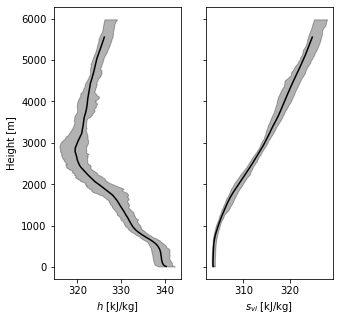

In [4]:
#%% Plot averaged h, svl profiles

zmin = 20 # Lowerst z value to plot
zmax = 6000 # Highest z value to plot (not included)
qu = 25
fE = 1e-3 # J-> kJ

izmin = np.where(z >= zmin)[0][0]
izmax = np.where(z < zmax)[0][-1]

hm, hmin, hmax = jf.mmm(h,qu)
svlm, svlmin, svlmax = jf.mmm(svl,qu)

fig, axs = plt.subplots(ncols=2,figsize=(5,5),sharey=True)

axs[0].set_xlabel(r'$h$ [kJ/kg]')
axs[0].set_ylabel(r'Height [m]')
axs[0].plot(hm[izmin:izmax]*fE,z[izmin:izmax],c='k')
axs[0].fill_betweenx(z[izmin:izmax],hmin[izmin:izmax]*fE,hmax[izmin:izmax]*fE,color='k',alpha=0.3)

axs[1].set_xlabel(r'$s_{vl}$ [kJ/kg]')
axs[1].plot(svlm[izmin:izmax]*fE,z[izmin:izmax],c='k')
axs[1].fill_betweenx(z[izmin:izmax],svlmin[izmin:izmax]*fE,svlmax[izmin:izmax]*fE,color='k',alpha=0.3)


# axs[0].legend(loc='best',bbox_to_anchor=(-0.3,1))
# plt.savefig('h-svl.pdf',bbox_inches='tight')
plt.show()

### Calculate budgets of moist static energy ($h$) and virtual liquid static energy ($s_{vl}$)
Assuming:
- z-coordinates
- One budget per circling set (3 consecutive circles) on a flight day (2 circling sets per flight day), only for those flown by HALO (6 circles)
- A day-averaged radiative tendency (because I'm too lazy to decompose sondes by circle)
- 2nd order central differences in space (which are **very** noisy)
- Linear regression fit over circling set to estimate tendencies, following Albright et al. (2022); Vogel et al. (2022)
- The circles are unsaturated in the mean, and advection of liquid water is small, so budgets for svl (which we can make for non-precipitating convection) are reasonable approximations of the budgets of s (which we can't make since we don't know ql)
- No horizontal fluxes across circle boundary (may be a problem especially on cold pool days?)
- $s_{vl}$ is unaffected by precipitation. I have no idea how bad that assumption is.

In [5]:
## Strategy for doing circling means (in line with ALA, RV)
# 1. You need to see if your dxdt estimates change at all if you calculate them based on 3 consecutive circles,
#    and if you calcualte them using lin. reg.
# 2. If yes, then adopt the strategy ALA/RV use, if not, this bit can stay the same
# 3. Then you have to subset on circling mean. If 1. says you need to calculate it on the 3-circle basis, then subset 
#    just this variable on that time (the others can stay on a per-circle scale)
#    If 1. says it's okay, then keep this cell and add a cell that does the averages on its own, and then uses that for
#    all subsequent analysis

ncircles = 6 # Always 6 circles on filtered days
nset = 3 # Always 3 circles in a circling mean set
nsets = ncircles // nset
zmin = 30 # Lowerst z value to plot => Attempt to avoid nans
zmax = 7000 # Highest z value (not included)

izmin = np.where(z >= zmin)[0][0]
izmax = np.where(z < zmax)[0][-1]
zflim = z[izmin:izmax]

# Budget arrays (date, circle, height)
h_tend = np.zeros((len(dates_unique),ncircles,len(zflim)))
h_hadv = np.zeros((len(dates_unique),ncircles,len(zflim)))
h_vadv = np.zeros((len(dates_unique),ncircles,len(zflim)))
h_sour = np.zeros((len(dates_unique),ncircles,len(zflim)))
h_radi = np.zeros((len(dates_unique),ncircles,len(zflim)))

h_tend_reg = np.zeros((len(dates_unique),nsets,len(zflim)))

svl_tend = np.zeros((len(dates_unique),ncircles,len(zflim)))
svl_hadv = np.zeros((len(dates_unique),ncircles,len(zflim)))
svl_vadv = np.zeros((len(dates_unique),ncircles,len(zflim)))
svl_sour = np.zeros((len(dates_unique),ncircles,len(zflim)))
svl_radi = np.zeros((len(dates_unique),ncircles,len(zflim)))

svl_tend_reg = np.zeros((len(dates_unique),nsets,len(zflim)))

svl_grad = np.zeros((len(dates_unique),ncircles,len(zflim)))
h_grad = np.zeros((len(dates_unique),ncircles,len(zflim)))

h_stor = np.zeros((len(dates_unique),ncircles,len(zflim)))
svl_stor = np.zeros((len(dates_unique),ncircles,len(zflim)))
w_stor = np.zeros((len(dates_unique),ncircles,len(zflim)))
U_stor = np.zeros((len(dates_unique),ncircles,len(zflim)))
D_stor = np.zeros((len(dates_unique),ncircles,len(zflim)))
rho_stor = np.zeros((len(dates_unique),ncircles,len(zflim)))
p_stor = np.zeros((len(dates_unique),ncircles,len(zflim)))
time_stor = np.empty((len(dates_unique),ncircles),dtype=object)

ibudg = []
for i in range(len(dates_unique)):
    # Find day
    idi = jf.find_inds_day(dates_unique[i],dates,ac='HALO',acs=acs)
    print(dates_unique[i])
    
    # Exclude day if less than 6 circles flown
    if len(idi) < ncircles:
        print('Excluding, too few HALO circles for budget...')
        continue

    # Get time since first circle in seconds
    timei = time[idi]
    timei_sec = ((timei - timei[0])/np.timedelta64(1, 's')).astype(np.float64)
    
    # Is any level of the circle super-saturated in the mean? If yes, you really cannot ignore ql
    # which you do not know
    if np.max(rh[idi,:]) > 100:
        print('Max rh>100 - you cannot ignore liquid water effects')

    # Get circle radiation data from HALO
    # Find which time indices are in that of the current date and are HALO
    idi_rad = jf.find_rad_inds_flight_day(time_rad, timei[0], platform_rad)    
    
    ## BUDGETS ##

    # Variables
    hi = h[idi,izmin:izmax]
    svli = svl[idi,izmin:izmax]
    ui = u[idi, izmin:izmax]
    vi = v[idi, izmin:izmax]
    Di = D[idi, izmin:izmax]
    wi = w[idi, izmin:izmax]
    omegai = omega[idi, izmin:izmax]
    rhoi = rho[idi, izmin:izmax]
    pi = p[idi, izmin:izmax]
    dTdxi = dTdx[idi,izmin:izmax]
    dTdyi = dTdy[idi,izmin:izmax]
    dpdxi = dpdx[idi,izmin:izmax]
    dpdyi = dpdy[idi,izmin:izmax]
    dqdxi = dqdx[idi,izmin:izmax]
    dqdyi = dqdy[idi,izmin:izmax]
    q_radi = q_rad[idi_rad,izmin:izmax]
    
    # Variables to store
    for j in range(len(timei_sec)):
        time_stor[i,j] = datetime.strptime(str(timei[j])[:19],'%Y-%m-%dT%H:%M:%S')
    h_stor[i,:,:] = hi
    svl_stor[i,:,:] = svli
    w_stor[i,:,:] = wi
    D_stor[i,:,:] = Di
    U_stor[i,:,:] = np.sqrt(ui**2 + vi**2)
    rho_stor[i,:,:] = rhoi
    p_stor[i,:,:] = pi

    # Tendency, central differences -> A bit sensitive to discretisation, but not enough to change main picture
    ddt = fd.FinDiff(0,timei_sec)
    h_tendi = ddt(hi)
    svl_tendi = ddt(svli)
    
    # Estimate tendency following ALA - regressing over first and last three circles
    for j in range(nsets):
        poly_coef = np.polyfit(timei_sec[j*nset:(j+1)*nset], hi[j*nset:(j+1)*nset,:], 1)
        h_tend_reg[i,j,:] = poly_coef[0,:]
        
        poly_coef = np.polyfit(timei_sec[j*nset:(j+1)*nset], svli[j*nset:(j+1)*nset,:], 1)
        svl_tend_reg[i,j,:] = poly_coef[0,:]
        
    # Horizontal advection in z-coordinates.
    h_hadvi   = thermo.cp * (ui*dTdxi + vi*dTdyi) + thermo.rlv*(ui*dqdxi + vi*dqdyi)
    svl_hadvi = thermo.cp * (ui*dTdxi + vi*dTdyi) + 0.608*thermo.cp*thermo.T0*(ui*dqdxi + vi*dqdyi)

    # Vertical advection (z-coordinates) -> central differences, also not overly affected by order
    ddz = fd.FinDiff(1,z[1]-z[0])
    
    h_gradi = ddz(hi)
    h_vadvi = wi * h_gradi

    svl_gradi = ddz(svli)
    svl_vadvi = wi * svl_gradi

    # Radiation
    h_radii = thermo.cp * np.mean(q_radi,axis=0)
    svl_radii = thermo.cp * np.mean(q_radi,axis=0)
    
    # Apparent sources (i.e. approximations of flux divergence)
    # Only works with day-mean radiation, because too I'm too lazy to calculate
    # heating rates per circle
    h_souri   = h_tendi + h_hadvi + h_vadvi - h_radii[np.newaxis,:]
    svl_souri = svl_tendi+ svl_hadvi + svl_vadvi - svl_radii[np.newaxis,:]
    
    h_tend[i,:,:] = h_tendi
    h_hadv[i,:,:] = h_hadvi
    h_vadv[i,:,:] = h_vadvi
    h_radi[i,:,:] = h_radii
    h_sour[i,:,:] = h_souri

    svl_tend[i,:,:] = svl_tendi
    svl_hadv[i,:,:] = svl_hadvi
    svl_vadv[i,:,:] = svl_vadvi
    svl_radi[i,:,:] = svl_radii
    svl_sour[i,:,:] = svl_souri
    
    svl_grad[i,:,:] = svl_gradi
    h_grad[i,:,:] = h_gradi
    
    ibudg.append(i)

# Filter the days that nothing was computed
h_tend = h_tend[ibudg,:,:]
h_hadv = h_hadv[ibudg,:,:]
h_vadv = h_vadv[ibudg,:,:]
h_radi = h_radi[ibudg,:,:]
h_sour = h_sour[ibudg,:,:]

h_tend_reg = h_tend_reg[ibudg,:,:]

svl_tend = svl_tend[ibudg,:,:]
svl_hadv = svl_hadv[ibudg,:,:]
svl_vadv = svl_vadv[ibudg,:,:]
svl_radi = svl_radi[ibudg,:,:]
svl_sour = svl_sour[ibudg,:,:]

svl_tend_reg = svl_tend_reg[ibudg,:,:]

svl_grad = svl_grad[ibudg,:,:]
h_grad = h_grad[ibudg,:,:]

h_stor = h_stor[ibudg,:,:]
svl_stor = svl_stor[ibudg,:,:]
w_stor = w_stor[ibudg,:,:]
D_stor = D_stor[ibudg,:,:]
U_stor = U_stor[ibudg,:,:]
rho_stor = rho_stor[ibudg,:,:]
time_stor = time_stor[ibudg,:]

0117
Excluding, too few HALO circles for budget...
0119
Excluding, too few HALO circles for budget...
0122
0123
Excluding, too few HALO circles for budget...
0124
0126
0128
0131
0202
0203
Excluding, too few HALO circles for budget...
0204
Excluding, too few HALO circles for budget...
0205
0207
0209
0210
Excluding, too few HALO circles for budget...
0211
Excluding, too few HALO circles for budget...
0213
0215
Excluding, too few HALO circles for budget...


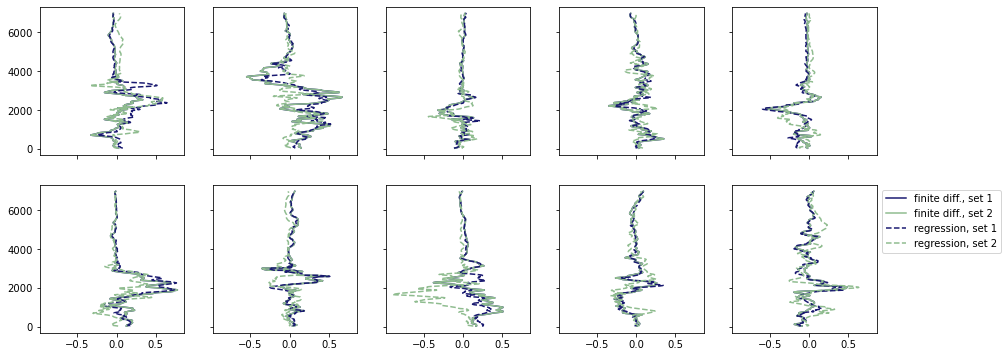

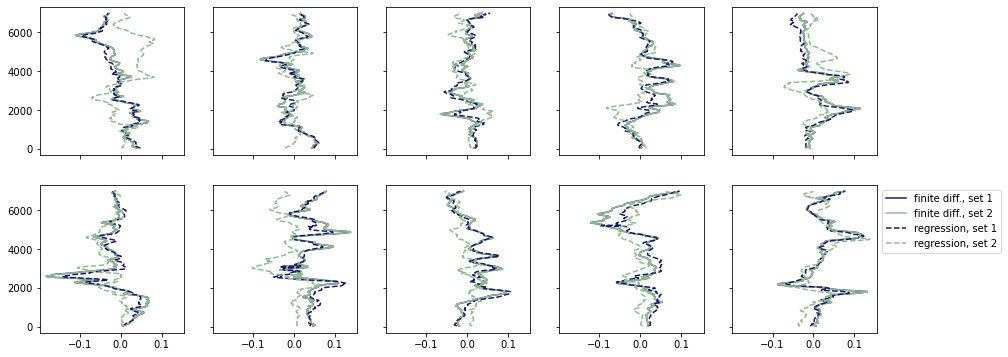

In [6]:
# Compare least-squares tendency estimates to finite difference estimates

cs = ['midnightblue','darkseagreen']
nprofs = h_tend.shape[0]*nsets
ncols = 5
nrows = h_tend.shape[0]//ncols # FIXME might break

fig,axs = plt.subplots(figsize=(ncols*3,nrows*3), nrows=nrows, ncols=ncols, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(h_tend.shape[0]):
    h_tend0 = np.mean(h_tend[i,:3,:],axis=0)
    h_tend1 = np.mean(h_tend[i,:3,:],axis=0)
    
    axs[i].plot(h_tend0, zflim, c=cs[0], label='finite diff., set 1')
    axs[i].plot(h_tend1, zflim, c=cs[1], label='finite diff., set 2')
    axs[i].plot(h_tend_reg[i,0,:],zflim, c=cs[0], linestyle ='--', label='regression, set 1')
    axs[i].plot(h_tend_reg[i,1,:],zflim, c=cs[1], linestyle ='--', label='regression, set 2')
axs[-1].legend(bbox_to_anchor=(1,1),loc='best')
plt.show()

fig,axs = plt.subplots(figsize=(ncols*3,nrows*3), nrows=nrows, ncols=ncols, sharex=True, sharey=True)
axs = axs.flatten()
for i in range(svl_tend.shape[0]):
    svl_tend0 = np.mean(svl_tend[i,:3,:],axis=0)
    svl_tend1 = np.mean(svl_tend[i,:3,:],axis=0)
    
    axs[i].plot(svl_tend0, zflim, c=cs[0], label='finite diff., set 1')
    axs[i].plot(svl_tend1, zflim, c=cs[1], label='finite diff., set 2')
    axs[i].plot(svl_tend_reg[i,0,:],zflim, c=cs[0], linestyle ='--', label='regression, set 1')
    axs[i].plot(svl_tend_reg[i,1,:],zflim, c=cs[1], linestyle ='--', label='regression, set 2')
axs[-1].legend(bbox_to_anchor=(1,1),loc='best')
plt.show()


# Mmmh, it's not perfect... Let's adopt the ALA/RV estimate for now!

In [7]:
# Set tendency estimates to circling mean regression fit following ALA

h_tend = h_tend_reg
svl_tend = svl_tend_reg

/Users/martinjanssens/opt/anaconda3/envs/venv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


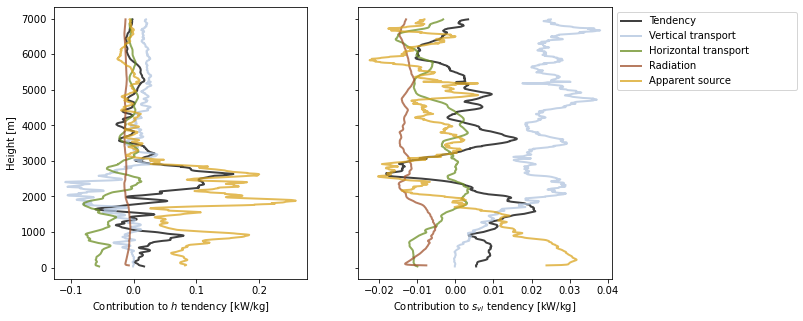

In [34]:
# Plot the budget terms over whole campaign

terms = ['Tendency                               ',
         'Vertical transport',
         'Horizontal transport',
         'Radiation',
         'Apparent source'
         ]

colors = ['black',
          'lightsteelblue',
          'olivedrab',
          'sienna',
          'goldenrod',
          ]

alpha = 0.75
alphaf = 0.2
lw = 2
fh = 1
fs = 1
qu = 25

h_tendmn, h_tendmin, h_tendmax = jf.mmm(h_tend,qu)
h_hadvmn, h_hadvmin, h_hadvmax = jf.mmm(h_hadv,qu)
h_vadvmn, h_vadvmin, h_vadvmax = jf.mmm(h_vadv,qu)
h_radimn, h_radimin, h_radimax = jf.mmm(h_radi,qu)
h_sourmn, h_sourmin, h_sourmax = jf.mmm(h_sour,qu)

svl_tendmn, svl_tendmin, svl_tendmax = jf.mmm(svl_tend,qu)
svl_hadvmn, svl_hadvmin, svl_hadvmax = jf.mmm(svl_hadv,qu)
svl_vadvmn, svl_vadvmin, svl_vadvmax = jf.mmm(svl_vadv,qu)
svl_radimn, svl_radimin, svl_radimax = jf.mmm(svl_radi,qu)
svl_sourmn = np.mean(svl_sour,axis=(0,1))

fig,axs = plt.subplots(ncols=2,sharey=True,figsize=(10,5))
axs[0].plot(h_tendmn*fh, zflim,c=colors[0],alpha=alpha,lw=lw)
# axs[0].fill_betweenx(zflim,h_tendmin*fh,h_tendmax*fh,color=colors[0],alpha=alphaf)
axs[0].plot(-h_vadvmn*fh, zflim,c=colors[1],alpha=alpha,lw=lw)
# axs[0].fill_betweenx(zflim,-h_vadvmax*fh,-h_vadvmin*fh,color=colors[1],alpha=alphaf)
axs[0].plot(-h_hadvmn*fh, zflim,c=colors[2],alpha=alpha,lw=lw)
# axs[0].fill_betweenx(zflim,-h_hadvmax*fh,-h_hadvmin*fh,color=colors[2],alpha=alphaf)
axs[0].plot(h_radimn*fh, zflim,c=colors[3],alpha=alpha,lw=lw)
# axs[0].fill_betweenx(zflim,h_radimin*fh,h_radimax*fh,color=colors[3],alpha=alphaf)
axs[0].plot(h_sourmn*fh, zflim,c=colors[4],alpha=alpha,lw=lw)
# axs[0].fill_betweenx(zflim,h_sourmin*fh,h_sourmax*fh,color=colors[4],alpha=alphaf)
axs[0].set_xlabel(r"Contribution to $h$ tendency [kW/kg]")

axs[1].plot(svl_tendmn*fs, zflim,c=colors[0],label=terms[0],alpha=alpha,lw=lw)
axs[1].plot(-svl_vadvmn*fs, zflim,c=colors[1],label=terms[1],alpha=alpha,lw=lw)
axs[1].plot(-svl_hadvmn*fs, zflim,c=colors[2],label=terms[2],alpha=alpha,lw=lw)
axs[1].plot(svl_radimn*fs, zflim,c=colors[3],label=terms[3],alpha=alpha,lw=lw)
axs[1].plot(svl_sourmn*fs, zflim,c=colors[4],label=terms[4],alpha=alpha,lw=lw)
axs[1].set_xlabel(r"Contribution to $s_{vl}$ tendency [kW/kg]")

axs[0].set_ylabel(r'Height [m]')
axs[1].legend(loc='upper left',bbox_to_anchor=(1,1))


### NOTES
- General shapes seem right:
 - Tendencies show double peak of moistening (associated with shallow and deep population), like LES typically does
 - Apparent sources have a similar shape as vertical flux divergences typically do: Double moistening peak and quasi-linearly decreasing heating, with inversion cooling
- Rather large amounts of inversion moistening and cooling
- The variability around the campaign mean structure is of similar magnitude as the mean structure, for all processes
- Radiation does not well balance the vertical transport above cloud layer
- Resulting in the inferred svl flux divergence not returning to 0?

### Plot vertical profiles per day
1. Of the budget terms, to determine the first order balances on each day
2. Of vertical velocity, to assess whether its slopes change in the cloud layer (indicative of circulations), or whether its structure is just imposed by free-tropospheric variability (of which there is a lot!)
3. Of horizontal velocity, to get an indication of how much advection can be expected to move (potential) circulating structures through the circle throughout the day

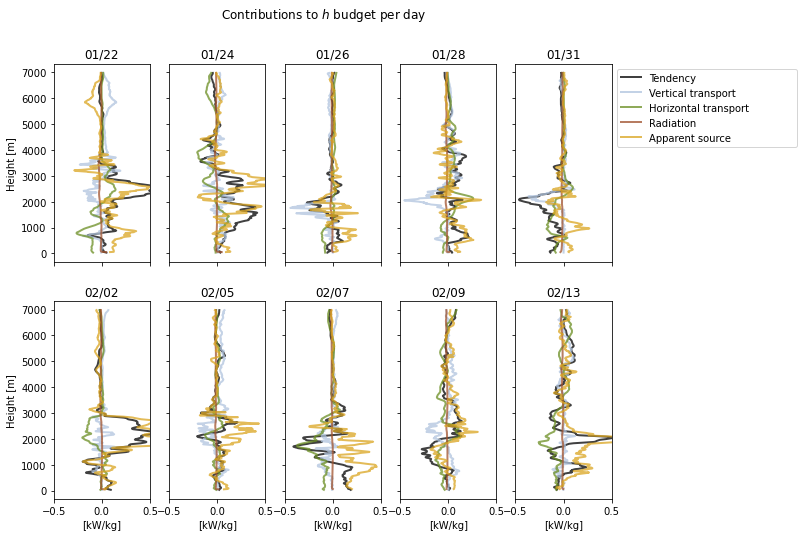

In [36]:
## BUDGETS ##
# h
ncols = 5
title = 'Contributions to $h$ budget per day'
xlim = 0.5
xlab = '[kW/kg]'

budget_terms = np.stack([ np.mean(h_tend,axis=1),
                         -np.mean(h_vadv,axis=1),
                         -np.mean(h_hadv,axis=1),
                          np.mean(h_radi,axis=1),
                          np.mean(h_sour,axis=1)
                         ],axis=0)
axs = jf.plot_per_day(budget_terms, terms, ibudg, dates_unique, zflim, colors, ncols, title, xlim=xlim, xlab=xlab)

### NOTES
- Circle-mean flux divergence (or, more accurately, the apparent h source) to first order sets the h-tendency
- The variability between days is enormous in all terms save the radiation
- Inversion-layer moistening is usually paired with inversion-layer advective drying => Outflows?

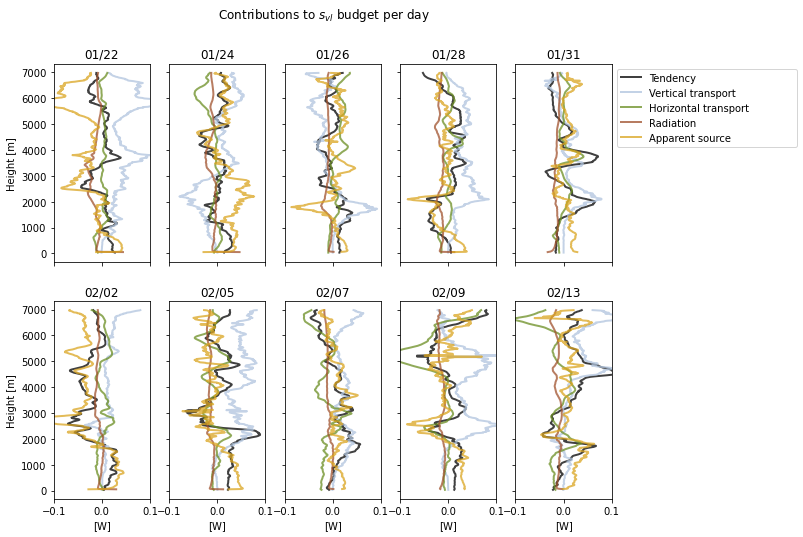

In [10]:
# svl
title = 'Contributions to $s_{vl}$ budget per day'
xlim = 0.1
xlab = '[kW/kg]'

budget_terms = np.stack([ np.mean(svl_tend,axis=1),
                         -np.mean(svl_vadv,axis=1),
                         -np.mean(svl_hadv,axis=1),
                          np.mean(svl_radi,axis=1),
                          np.mean(svl_sour,axis=1)
                         ],axis=0)
axs = jf.plot_per_day(budget_terms, terms, ibudg, dates_unique, zflim, colors, ncols, title, xlim=xlim, xlab=xlab)

### NOTES
- Rarely is *mean* balance in good WTG approximation, i.e. mean heating tendency is rarely small, though horizontal advection usually is
- But quite often are vertical transport and apparent source (~flux divergence) the largest budget terms. They often balance in inversion-layer (24/01, 26/01, 09/02), i.e. you can infer inversion-layer vertical velocity from the heating rates on several days, in good agreement with WTG
- Radiation is rather constant and small

## Estimate correlations for (hypothesised) feedback mechanisms

### Parameterisation for $w$ 
> **Note:** Not currently in use anywhere, as it doesn't work that well

Attempt to separate $w$ contributions from large-scale subsidence and boundary-layer-scale circulations, i.e.
\begin{equation}
    w = w_0\psi_0 + w_1\psi_1 + w_2
\end{equation}
where:
 - $\psi_0$ attempts to parameterise the mean subsiding environment
 - $\psi_1$ attempts to parameterise boundary-layer-scale circulations
 - $w_2 = \sum_i^\infty \psi_iw_i$ (i.e. the remainder, e.g. waves, FT disturbances...)

In [11]:
from scipy.signal import peak_widths,find_peaks
from scipy.optimize import curve_fit

# 1. Set scale heights

# a) Subsidence scale height for psi0
z0 = 2500. # Set
rhob = np.mean(rho_stor,axis=(0,1)) # Campaign-mean density

# b) Find inversion heights with peak detection in svl gradient
#    (this isn't always totally accurate, but it will do for setting the heights)
zinvmin = 1100 # Inversion will not be below this height
svl_grad_day = np.mean(svl_grad,axis=1)
svl_day = np.mean(svl_stor,axis=1)

zinv = np.zeros(svl_day.shape[0]) # Centre of inversion
zib = np.zeros(svl_day.shape[0])  # Inversion base
zit = np.zeros(svl_day.shape[0])  # Inversion top

for i in range(svl_day.shape[0]):
    ipeakgrad,peakprop = find_peaks(svl_grad_day[i,:],width=20)
    ipkeaninv = ipeakgrad[zflim[ipeakgrad]>zinvmin][0]
    _,_,iinvmin,iinvmax = peak_widths(svl_grad_day[i,:],[ipkeaninv])
    zinv[i] = zflim[ipkeaninv]
    zib[i] = zflim[int(iinvmin[0])]
    zit[i] = zflim[int(iinvmax[0])]
    
#     zinvs = zflim[[int(iinvmin[0]),ipkeaninv,int(iinvmax[0])]]
#     plt.plot(svl_day[i],zflim)
#     plt.hlines(zinvs,svl_day[i].min(),svl_day[i].max())
#     plt.show()
#     plt.plot(svl_grad_day[i],zflim)
#     plt.hlines(zinvs,svl_grad_day[i].min(),svl_grad_day[i].max())
#     plt.show()

def w_0(z, w0, H0):
    psi0 = (1-np.exp(-z/H0))
    return psi0*w0

# FIXME Not decided whether to scale psi1 with rho/rho0 to squash it appropriately with height, 
# or just set to zero above 2*z1
def w_1(z, w1, H1):
    psi1 = np.sin(2.*np.pi/H1*z)*rhob/rhob[0]
#     psi1[z>H1] = 0.
    return psi1*w1

def w_01(z, w0, w1, H0, H1):
    return w_0(z, w0, H0) + w_1(z, w1, H1)

# w coefficients [0,1]
wc0 = np.zeros((len(ibudg),ncircles))
wc1 = np.zeros((len(ibudg),ncircles))

# actual w[1:2]
w0 = np.zeros(w_stor.shape)
w1 = np.zeros(w_stor.shape)
w2 = np.zeros(w_stor.shape)

eps = 1e-5
for i in range(w_stor.shape[0]):
    for j in range(w_stor.shape[1]):
        z1 = 2*zinv[i]
        [wc0[i,j],wc1[i,j],_,_], pcov = curve_fit(w_01, zflim, w_stor[i,j,:],
                                                  p0=[-4e-3,-2.5e-3,z0,z1],
                                                  bounds=((-np.inf,-np.inf,z0-eps,z1-eps),
                                                          (np.inf,np.inf,z0+eps,z1+eps)))
        w0[i,j,:] = w_0(zflim, wc0[i,j], z0)
        w1[i,j,:] = w_1(zflim, wc1[i,j], z1)
        w2[i,j,:] = w_stor[i,j,:] - w0[i,j,:] - w1[i,j,:]

array([[<AxesSubplot:title={'center':'01/22'}, ylabel='Height [m]'>,
        <AxesSubplot:title={'center':'01/24'}>,
        <AxesSubplot:title={'center':'01/26'}>,
        <AxesSubplot:title={'center':'01/28'}>,
        <AxesSubplot:title={'center':'01/31'}>],
       [<AxesSubplot:title={'center':'02/02'}, xlabel='[W]', ylabel='Height [m]'>,
        <AxesSubplot:title={'center':'02/05'}, xlabel='[W]'>,
        <AxesSubplot:title={'center':'02/07'}, xlabel='[W]'>,
        <AxesSubplot:title={'center':'02/09'}, xlabel='[W]'>,
        <AxesSubplot:title={'center':'02/13'}, xlabel='[W]'>]],
      dtype=object)

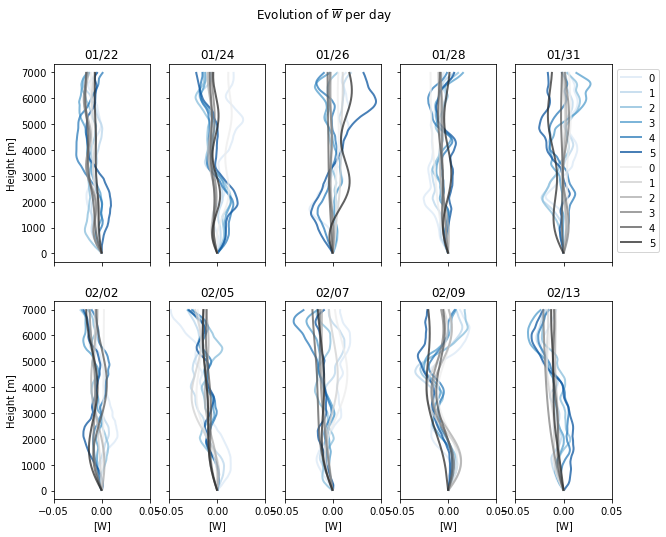

In [37]:
## VERTICAL VELOCITY (with parameterisation) ##
colors = ([plt.cm.Blues(i/(ncircles+1)) for i in range(ncircles+1)])[1:]
colors_k = ([plt.cm.Greys(i/(ncircles+1)) for i in range(ncircles+1)])[1:]

title = 'Evolution of $\overline{w}$ per day'
xlim = 0.05
ncols = 5
axs=jf.plot_per_day(np.swapaxes(w_stor, 0, 1), np.arange(ncircles), ibudg, dates_unique, zflim, colors, ncols, title=title,xlim=xlim,xlab='[m/s]')
jf.plot_per_day(np.swapaxes(w0+w1, 0, 1), np.arange(ncircles), ibudg, dates_unique, zflim, colors_k, ncols, title=title,xlim=xlim,axs=axs)

### Does the vertical velocity structure vary over a flight day?

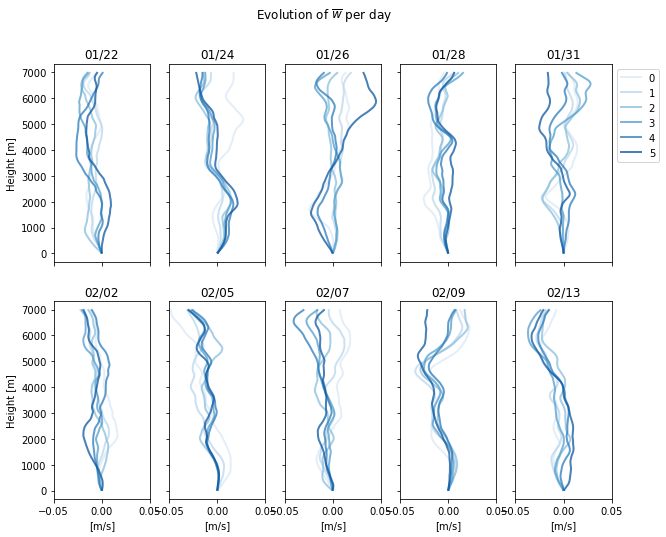

In [38]:
## VERTICAL VELOCITY (no parameterisation) ##
colors = ([plt.cm.Blues(i/(ncircles+1)) for i in range(ncircles+1)])[1:]
colors_k = ([plt.cm.Greys(i/(ncircles+1)) for i in range(ncircles+1)])[1:]

title = 'Evolution of $\overline{w}$ per day'
xlim = 0.05
ncols = 5
axs=jf.plot_per_day(np.swapaxes(w_stor, 0, 1), np.arange(ncircles), ibudg, dates_unique, zflim, colors, ncols, title=title,xlim=xlim,xlab='[m/s]')

### NOTES

- $w$ is extremely variable both on the intra- and inter-day time scale, there is hardly a situation where the classical Hadley cell-induced, steady subsidence is visible
- Circulating structures visible on most days (by eye 22/01, 26/01, 31/01, 02/02, 05/02, 07/02, 09/02)
- Often switches from one sign to another over a day -> Is this due to advection of the mean flow with the circulating structures in it? Do the circulations follow a diurnal pattern?

## Cloud-layer-averaged processes
- Averaged over the circling set, to be consistent with tendencies
- Not looking at column-integrated processes yet, because we're trying to relate anomalies in cloud-layer latent heating to cloud-layer vertical velocity and moistening (implying increased condensation and more cloudiness)

In [13]:
zmin = 500 # Lowerst z value (implied cloud base FIXME should compute this)

# Integrate up to inversion top

izminplt = np.where(zflim >= zmin)[0][0]

# h
h_int = np.zeros((len(ibudg),nsets))
h_tendint = np.zeros((len(ibudg),nsets))
h_vadvint = np.zeros((len(ibudg),nsets))
h_hadvint = np.zeros((len(ibudg),nsets))
h_radiint = np.zeros((len(ibudg),nsets))
h_sourint = np.zeros((len(ibudg),nsets))

# svl
svl_int = np.zeros((len(ibudg),nsets))
svl_tendint = np.zeros((len(ibudg),nsets))
svl_vadvint = np.zeros((len(ibudg),nsets))
svl_hadvint = np.zeros((len(ibudg),nsets))
svl_radiint = np.zeros((len(ibudg),nsets))
svl_sourint = np.zeros((len(ibudg),nsets))

# Misc
svl_gradint = np.zeros((len(ibudg),nsets))
w_int = np.zeros((len(ibudg),nsets))
w0_int = np.zeros((len(ibudg),nsets))
w1_int = np.zeros((len(ibudg),nsets))
U_int = np.zeros((len(ibudg),nsets))
norm = np.zeros((len(ibudg),ncircles)) # Circle
norm_c = np.zeros((len(ibudg),nsets)) # Circling mean
h_vadvint_wtg = np.zeros((len(ibudg),nsets))
h_vadvint_w1 = np.zeros((len(ibudg),nsets))
div_cloud = np.zeros((len(ibudg),nsets))
div_subcloud = np.zeros((len(ibudg),nsets))

# at circling mean scale
rho_c = rho_stor.reshape((len(ibudg),nsets,nset,len(zflim))).mean(axis=2)

for i in range(len(ibudg)):
    izmaxplt = np.argmin(np.abs(zflim-zit[i]))
    zfplt = zflim[izminplt:izmaxplt]
    
    norm[i,:] = jf.vint(np.ones((ncircles,len(zfplt))),rho_stor[i,:,izminplt:izmaxplt],zfplt)
    norm_c[i,:] = jf.vint(np.ones((ncircles,len(zfplt))),rho_stor[i,:,izminplt:izmaxplt],zfplt).reshape((nsets,nset)).mean(axis=1)
    
    h_tendint[i,:] = jf.vint(h_tend[i,:,izminplt:izmaxplt],rho_c[i,:,izminplt:izmaxplt],zfplt)/norm_c[i,:]
    h_vadvint[i,:] = (jf.vint(h_vadv[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    h_hadvint[i,:] = (jf.vint(h_hadv[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    h_radiint[i,:] = (jf.vint(h_radi[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    h_sourint[i,:] = (jf.vint(h_sour[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)

    svl_tendint[i,:] = jf.vint(svl_tend[i,:,izminplt:izmaxplt],rho_c[i,:,izminplt:izmaxplt],zfplt)/norm_c[i,:]
    svl_vadvint[i,:] = (jf.vint(svl_vadv[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    svl_hadvint[i,:] = (jf.vint(svl_hadv[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    svl_radiint[i,:] = (jf.vint(svl_radi[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    svl_sourint[i,:] = (jf.vint(svl_sour[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)

    h_int[i,:] = (jf.vint(h_stor[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)

    svl_gradint[i,:] = (jf.vint(svl_grad[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    w_int[i,:] = (jf.vint(w_stor[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    w0_int[i,:] = (jf.vint(w0[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    w1_int[i,:] = (jf.vint(w1[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    U_int[i,:] = (jf.vint(U_stor[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)

    h_vadvint_wtg[i,:] = (jf.vint((svl_sour*h_grad/svl_grad)[i,:,izminplt:izmaxplt],
                            rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    
    h_vadvint_w1[i,:] = (jf.vint((w1*h_grad)[i,:,izminplt:izmaxplt], rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)

    div_cloud[i,:] = (jf.vint(D_stor[i,:,izminplt:izmaxplt],rho_stor[i,:,izminplt:izmaxplt],zfplt)/norm[i,:]).reshape((nsets,nset)).mean(axis=1)
    div_subcloud[i,:] = (jf.vint(D_stor[i,:,:izminplt],rho_stor[i,:,:izminplt],zflim[:izminplt])/
                         jf.vint(np.ones((ncircles,izminplt)),rho_stor[i,:,:izminplt],zflim[:izminplt])).reshape((nsets,nset)).mean(axis=1)

# Circulations (as per Geet's ratio)
icirc = np.zeros(div_cloud.shape,dtype=bool)
icirc[div_cloud/div_subcloud < 0] = 1
print('Fraction of circling sets where subcloud and cloud layer divergence oppose in sign:',
      np.sum(icirc)/icirc.size)

Fraction of circling sets where subcloud and cloud layer divergence oppose in sign: 0.65


Text(0, 0.5, 'Cloud-layer divergence')

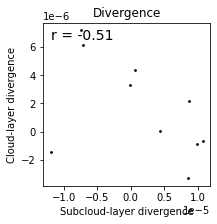

In [14]:
# Attempt to reproduce Geet's figure

field_x = np.mean(div_subcloud,axis=1)
field_y = np.mean(div_cloud,axis=1)

title = 'Divergence'
xlabel = 'Subcloud-layer divergence'
ylabel = 'Cloud-layer divergence'

fig,axs = plt.subplots(ncols=1,nrows=1,figsize=(3,3))

r_x_y = pearsonr(field_x.flatten(),field_y.flatten())[0]
axs.scatter(field_x,field_y,c='k',s=3)
axs.annotate('r = %.2f'%r_x_y, (0.05,0.9), xycoords='axes fraction', fontsize=14)
axs.set_title(title)
axs.set_xlabel(xlabel)
axs.set_ylabel(ylabel)

Not too far away -> happy to proceed

### Hypothesis 1 (Janssens et al., 2022) - Moisture-convection feedback

Required correlations for mechanism:
1. Vertical advection of $h$ should correlate to the tendency of $h$ (i.e. cloud-layer convergence/divergence should lead to moistening/drying), reflecting $\partial_t h' \sim -w'\Gamma_h$
2. Weak-temperature gradient should ensure fluctuations in the apparent $s_{vl}$ source correlate to fluctuations in vertical velocity, reflecting $w'\Gamma_{s_{vl}} \sim Q_{s_{vl}}$, and in combination with 1. $-w'\Gamma_h \sim Q_{s_{vl}}\Gamma_h/\Gamma_{s_{vl}}$
3. Moister columns should correlate to stronger $s_{vl}$ release through larger, negative heat flux divergences, reflecting $Q_{s_{vl}} \sim w^* h'$

Assumptions that we cannot (currently) account for:
- Fluctuations $\cdot'$ are here captured as variability relative to campaign-mean, while the mechanism explicitly assumes them to be fluctuations with respect to a spatial mean. This matters, because the circulations and their effects are spatial structures, not temporal ones. In short, we don't know if the variability observed here is due to circulations, or some other process. 
- The terms we measure also aren't exactly the right terms. For instance, we look at $(w\Gamma_h)'$ instead of $w'\Gamma_h$.
- We assume the budgets are not overly affected by horizontal advection of circulating structures in and out of the circle, which clouded the budgets in LES if you kept the averaging-domain fixed in space.
- Effects of precipitation on the feedback
- The computed budgets approximately close and are robust to choices in how to represent their terms

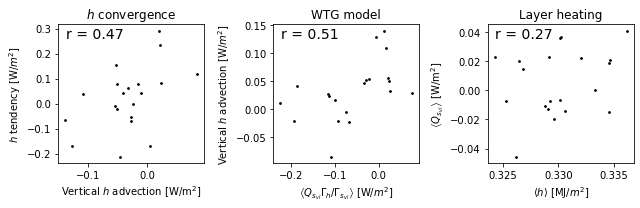

In [55]:
# Basic scatter plots to see if there is any connection for entire campaign

fig,axs =  plt.subplots(ncols=3,nrows=1,figsize=(9,3))

r_h_vadv_tend = pearsonr(-h_vadvint.flatten(),h_tendint.flatten())[0]
# r_h_vadv_tend_circ = pearsonr(-(h_vadvint[icirc]).flatten(),(h_tendint[icirc]).flatten())[0]
axs[0].scatter(-h_vadvint,h_tendint,c='k',s=3)
axs[0].annotate('r = %.2f'%r_h_vadv_tend, (0.05,0.9), xycoords='axes fraction', fontsize=14)
# axs[0].annotate('r = %.2f'%r_h_vadv_tend_circ, (0.05,0.8), xycoords='axes fraction', fontsize=14)
axs[0].set_title('$h$ convergence')
axs[0].set_xlabel('Vertical $h$ advection [W/m$^2$]')
axs[0].set_ylabel('$h$ tendency [W/$m^2$]')

r_h_vadvw_vadv = pearsonr(h_vadvint_wtg.flatten(),h_vadvint.flatten())[0]
r_h_vadvw_vadv_circ = pearsonr((h_vadvint_wtg[icirc]).flatten(),(h_vadvint[icirc]).flatten())[0]
axs[1].scatter(h_vadvint_wtg,h_vadvint,c='k',s=3)
axs[1].annotate('r = %.2f'%r_h_vadvw_vadv, (0.05,0.9), xycoords='axes fraction', fontsize=14)
# axs[1].annotate('r = %.2f'%r_h_vadvw_vadv_circ, (0.05,0.8), xycoords='axes fraction', fontsize=14)
# axs[1].set_xlim((-400,400))
# axs[1].set_ylim((-200,400))
axs[1].set_title('WTG model')
axs[1].set_xlabel(r"$\left\langle Q_{s_{vl}}\Gamma_{h}/\Gamma_{s_{vl}}\right\rangle$ [W/$m^2$]")
axs[1].set_ylabel('Vertical $h$ advection [W/$m^2$]')

r_h_h_q = pearsonr(h_int.flatten(),svl_sourint.flatten())[0]
r_h_h_q_circ = pearsonr((h_int[icirc]).flatten(),(svl_sourint[icirc]).flatten())[0]
axs[2].scatter(h_int/1e6,svl_sourint,c='k',s=3)
axs[2].annotate('r = %.2f'%r_h_h_q, (0.05,0.9), xycoords='axes fraction', fontsize=14)
# axs[2].annotate('r = %.2f'%r_h_h_q_circ, (0.05,0.8), xycoords='axes fraction', fontsize=14)
# axs[2].set_xlim((8.05e2,8.3e2))
# axs[2].set_ylim((-200,200))
axs[2].set_title('Layer heating')
axs[2].set_xlabel(r"$\left\langle h \right\rangle$ [MJ/$m^2$]")
axs[2].set_ylabel(r"$\left\langle Q_{s_{vl}}\right\rangle$ [W/m$^2$]")

plt.tight_layout()

### NOTES
1. Reasonable signal detected between:
 - Moistening and convergence of MSE in cloud-layer
 - WTG-predicted MSE convergence and actual MSE convergence
2. Small, but still positive relation detected between cloud-layer MSE and layer heating

Cannot refute the mechanism is there, but many uncertainties remain (assumptions above, modeling+sampling errors). **To do:** Still need to assess effects of these where possible.

### Causal relations?
Merely observing a correlation isn't good enough; if there were a feedback with timescale of a few hours you would hope to see it in consecutive circling means on individual days. Hence, the following 3 plots show the same relations as above, but for each day with its two circling-set means, to look for candidate days where the mechanism might be active.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


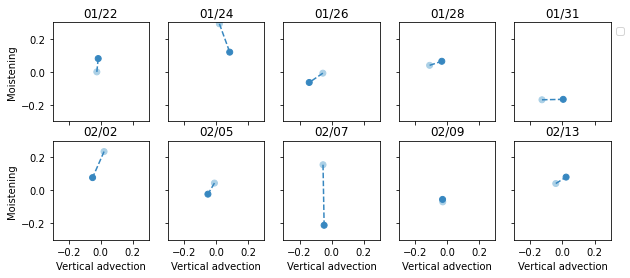

In [39]:
# Does the evolution of vertically integrated htend correlate to that of vadv, from one circling mean to the next?
colors = ([plt.cm.Blues(i/(nsets+1)) for i in range(nsets+1)])[1:]

axs=jf.scatter_per_day(-h_vadvint, h_tendint, np.arange(ncircles), ibudg, dates_unique, colors, ncols, 
                        title=None, xlab='Vertical advection', ylab='Moistening', fh=1, xlim=(-0.3,0.3),ylim=(-0.3,0.3),axs=[])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


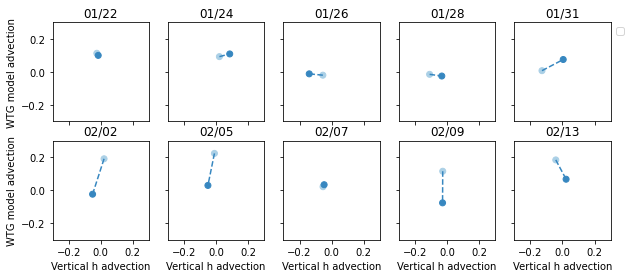

In [40]:
#%% Does the evolution of vertically integrated hvadv correlate to that of wtg estimate?
colors = ([plt.cm.Blues(i/(nsets+1)) for i in range(nsets+1)])[1:]
axs=jf.scatter_per_day(-h_vadvint,-h_vadvint_wtg , np.arange(ncircles), ibudg, dates_unique, colors, ncols, 
                        title=None, xlab='Vertical h advection',ylab='WTG model advection', fh=1, xlim=(-0.3,0.3),ylim=(-0.3,0.3),axs=[])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


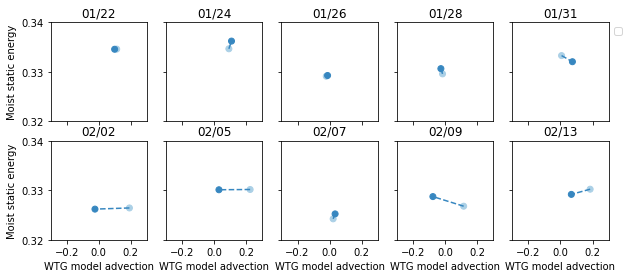

In [53]:
#%% Does the evolution of vertically integrated wtg-modelled hvadv correlate to that of moistening?
axs=jf.scatter_per_day(-h_vadvint_wtg, h_int/1e6, np.arange(ncircles), ibudg, dates_unique, colors, ncols, 
                        title=None, xlab='WTG model advection', ylab='Moist static energy', fh=1, xlim=(-0.3,0.3),ylim=(0.32,0.34),axs=[])

### NOTES
- Positive correlation consistent with either i) sampling the dry region of a spatially stationary circulation or ii) witnessing the passing from a moist to a dry region of a moving circulation visible on 02/02 and 05/02
- No other days exhibit the required structure. On 24/01 and 07/02 there is a positive relation between MSE and moisture convergence, but this gets overwhelmed by different budget terms to produce an opposite trend in the moistening.

In all, again appears to indicate that there are days where the mechanism might be active, but it remains uncertain.

### How do the other budget terms evolve?

Looking at the evolution of the budgets between the circling sets seems appropriate to gauge which (other) terms in the $h$ and $s_{vl}$ budgets (i.e. radiation, inferred source and horizontal advection) matter to the "mesoscale variability", i.e. to the dynamics over the time scale of several hours

/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/joanne-cloud-layer-circulation/joanne_functions.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(axs[i,j].get_xticks(), rotation=30, ha="right")
/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/joanne-cloud-layer-circulation/joanne_functions.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(axs[i,j].get_xticks(), rotation=30, ha="right")
/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/joanne-cloud-layer-circulation/joanne_functions.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(axs[i,j].get_xticks(), rotation=30, ha="right")
/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/joanne-cloud-layer-circulation/joanne_functions.py:128: UserWarning: FixedFormatter should onl

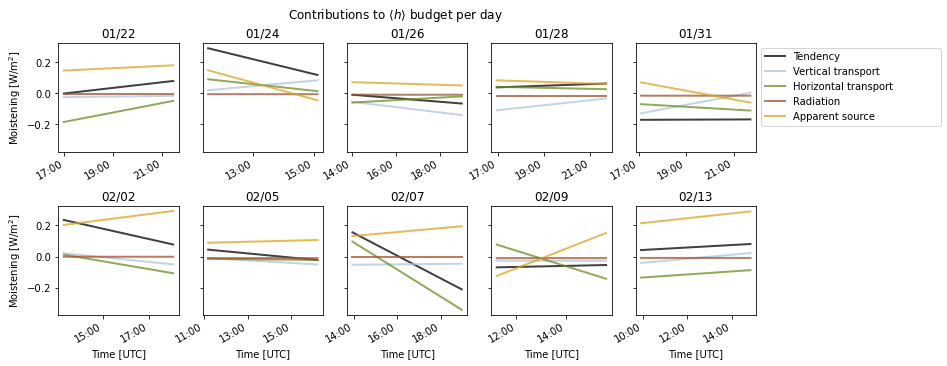

In [54]:
terms = ['Tendency                               ',
         'Vertical transport',
         'Horizontal transport',
         'Radiation',
         'Apparent source'
         ]

colors = ['black',
          'lightsteelblue',
          'olivedrab',
          'sienna',
          'goldenrod',
          ]

alpha = 0.75
lw = 2
fh = 1
ncols = 5
title = r"Contributions to $\langle h\rangle$ budget per day"
time_sets = time_stor.reshape((len(ibudg), nsets, nset))[:,:,1]

budget_terms = np.stack([ h_tendint,
                         -h_vadvint,
                         -h_hadvint,
                          h_radiint,
                          h_sourint
                         ],axis=0)
axs = jf.plot_per_day_time(budget_terms, time_sets, terms, ibudg, dates_unique, colors, ncols, 
                           title=title, xlab='Time [UTC]',ylab='Moistening [W/m$^2$]', fh=1, alpha=0.75, lw=2, 
                           ylim=(None,None),axs=[])

### NOTES
- Evolution of tendency between circling sets often set by different terms, i.e. all processes seem necessary. Consistent with only a few days correlating to the hypothesised mechanism.
- Horizontal advection often plays an important role in setting the tendency's evolution (22/01, 24/01, 02/02, 07/02, 13/02), indicating that import/export of circulating structures may obscure the relations observed above (i.e. we might sample the upwelling branch of a moisture-converging circulation with the first circling set, and then a few hours later a downwelling, moisture-exporting branch might have advected into the domain, leading us to measure a sudden strong, negative moisture advection). So the relation between vertical $h$ advection and its tendency may in fact be stronger than this data would lead us to observe.
- There also are days where the apparent source strongly relates to the tendency's evolution (22/01, 24/01, 13/02), i.e. where cloud-base moisture fluxes dominate the cloud-layer budget.

/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/joanne-cloud-layer-circulation/joanne_functions.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(axs[i,j].get_xticks(), rotation=30, ha="right")
/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/joanne-cloud-layer-circulation/joanne_functions.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(axs[i,j].get_xticks(), rotation=30, ha="right")
/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/joanne-cloud-layer-circulation/joanne_functions.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i,j].set_xticklabels(axs[i,j].get_xticks(), rotation=30, ha="right")
/Users/martinjanssens/Documents/Wageningen/EUREC4A/moisture_circulation/joanne-cloud-layer-circulation/joanne_functions.py:128: UserWarning: FixedFormatter should onl

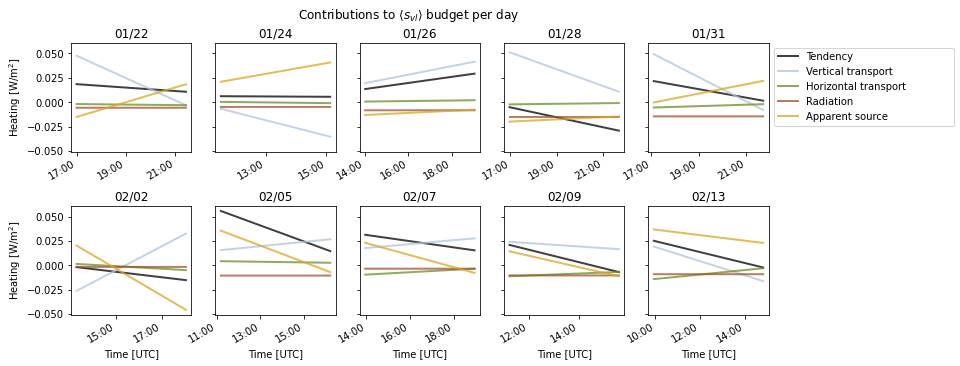

In [22]:
title = r"Contributions to $\langle s_{vl}\rangle$ budget per day"

colors = ['black',
          'lightsteelblue',
          'olivedrab',
          'sienna',
          'goldenrod',
          ]

budget_terms = np.stack([ svl_tendint,
                         -svl_vadvint,
                         -svl_hadvint,
                          svl_radiint,
                          svl_sourint
                         ],axis=0)
axs = jf.plot_per_day_time(budget_terms, time_sets, terms, ibudg, dates_unique, colors, ncols, 
                           title=title, xlab='Time [UTC]',ylab='Heating [W/m$^2$]', fh=1, alpha=0.75, lw=2, 
                           ylim=(None,None),axs=[])


### NOTES
- Like in the day-mean budgets, there are many days where the (opposite) evolution of vertical advection and the apparent source balance (22/01, 24/01, 31/01, 02/02, 05/02, 07/02), which would be indicative of the WTG interpretation we use (mesoscale fluctuations in a heat source are compensated by almost immediate ascent/descent along the stratification)
- Horizontal advection typically is small and doesn't change a lot, also consistent with WTG
- **FIXME** You still ignore intra-day variability in radiation

### Hypothesis 2 - feedback through cloud-base $h$ flux
If an increase in $h$ in cloud layer leads to more condensation, a stronger heat flux ($Q_{s_{vl}}$) and ascent ($w'$) (point 3 of the feedback discussed above), then you might also imagine:
1. That $w'$ in the cloud layer can be predicted by $Q_{s_{vl}}/\Gamma_{s_{vl}}$
2. That an increase in cloud-base $w'$ leads to an increase in moisture flux into the cloud layer, i.e. $w' \sim Q_{h}$
3. That this would lead to further moistening, i.e. $\partial_t h \sim Q_{h}$

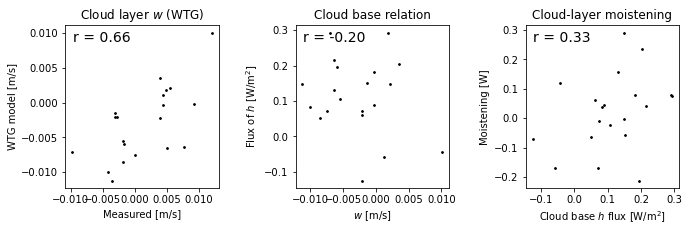

In [23]:
w_cloud_av     = w_int
w_cloud_av_wtg = svl_sourint / svl_gradint
div_cloud_av_wtg = w_cloud_av_wtg / (zflim[izmaxplt] - zflim[izminplt])

fig,axs =  plt.subplots(ncols=3,nrows=1,figsize=(11,3))

r_w_wtg = pearsonr(w_cloud_av_wtg.flatten(),w_cloud_av.flatten())[0]
axs[0].scatter(w_cloud_av_wtg,w_cloud_av,c='k',s=3)
axs[0].annotate('r = %.2f'%r_w_wtg, (0.05,0.9), xycoords='axes fraction', fontsize=14)
axs[0].set_title('Cloud layer $w$ (WTG)')
axs[0].set_xlabel('Measured [m/s]')
axs[0].set_ylabel('WTG model [m/s]')

r_w_hsour = pearsonr(w_cloud_av.flatten(),h_sourint.flatten())[0]
axs[1].scatter(w_cloud_av,h_sourint,c='k',s=3)
axs[1].annotate('r = %.2f'%r_w_hsour, (0.05,0.9), xycoords='axes fraction', fontsize=14)
# axs[1].set_xlim((-400,400))
# axs[1].set_ylim((-200,400))
axs[1].set_title('Cloud base relation')
axs[1].set_xlabel(r"$w$ [m/s]")
axs[1].set_ylabel('Flux of $h$ [W/m$^2$]')

r_hsour_htend = pearsonr(h_sourint.flatten(),h_tendint.flatten())[0]
axs[2].scatter(h_sourint,h_tendint,c='k',s=3)
axs[2].annotate('r = %.2f'%r_hsour_htend, (0.05,0.9), xycoords='axes fraction', fontsize=14)
axs[2].set_title('Cloud-layer moistening')
axs[2].set_xlabel(r"Cloud base $h$ flux [W/m$^2$]")
axs[2].set_ylabel('Moistening [W]')

plt.subplots_adjust(wspace=0.5)

### NOTES
- Cloud-layer $w$ variability is rather well-predicted by the WTG assumption (!)
- But there a **very small, negative** relation between vertical velocity in the cloud layer and a flux of $h$ at cloud base. So mesoscale ascent does not always enhance the moisture flux into the cloud layer. Discussion points:
 - Could be because you're not actually measuring the inversion in your budgets, but setting the top of the cloud layer. Cloud layers with a stronger moisture flux supply at their bottom may also reach deeper, so if you keep the inversion height fixed, you may measure an anomalous amount of export at the top which obscures your estimate.
 - The results seem consistent with Vogel et al. (2022), who do not observe an increase in mass flux into the cloud layer as it gets moister (i.e. no correlation between RH and M at cloud base).
 - It also is consistent with Janssens et al. (2022), in that (spatial) variability in cloud **base** fluxes don't scale very strongly with $w$; rather it is the fluxes higher in the layer that do.
- The cloud layer **does** respond to increases in the cloud-base $h$ fluxes, i.e. it moistens when we infer a net flux into the layer.

## Conclusions so far
We can't make strong statements about anything, pending
- Uncertainty quantification of the budgets. Do they close?
- More rigorous analysis of the effect of rather ambiguous choices:
 - Computing numerical approximations of derivatives
 - Ignoring variability in cloud-base and cloud-top heights in vertically-averged budgets
 - Ignoring the precipitation source on the budget of $s_{vl}$, and the intra-day radiation variability

Having said that, it seems like:
- There is evidence for the feedback observed in LES by Janssens et al. (2022) to occur on 02/02 and 05/02, both of which are days characterised by large, aggregated cloud structures. It's circumstantial evidence, but something.
- The WTG assumption holds rather well if you'd like to predict cloud-layer vertical velocity from (inferred) heat fluxes (though this may partially be by construction, since the source is not measured independently).